In [406]:
import csv
import keras
import matplotlib.pyplot as plt
import numpy as np
import os

from anytree import Node, RenderTree, Resolver, AnyNode, LevelOrderIter, PreOrderIter
from tqdm import tqdm_notebook, tqdm

Commandes pour générer les fichiers `.csv` depuis le dump envoyé par la DB :
```
ls | xargs -i basename {} .xlsx | xargs -i ssconvert {}.xlsx {}.csv
find -name '*.csv' | xargs -i wc -l {}
```

In [389]:
FILE_1 = './raw_data/h20162.csv'
FILE_2 = './raw_data/h20172.csv'
EMBEDDING_FILE_PATH = '/home/alexis/mva/word_embeddings/wiki.fr.vec'
WORD_EMBEDDING_SIZE = 300
ATTRIBUTES = ['tm', 'ms', 'pg', 'a', 'sa']
ATTRIBUTE_ID = ['id_tms', 'id_ms', 'id_pg', 'id_a', 'id_sa']
OUTPUT_FOLDER = 'output_data'
ROOT_NAME = 'root'

# Load word embeddings

Load FastText pretrained embeddings.

In [142]:
import gensim
from gensim.models import Word2Vec
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE_PATH, binary=False)

# Load Data

In [128]:
class Line:
    """Parser for rows of input CSV files"""

    def __init__(self, row):
        self.id_tms = row[1]
        self.tm = row[2]
        self.id_ms = row[3]
        self.ms = row[4]
        self.id_pg = row[5]
        self.pg = row[6]
        self.id_a = row[7]
        self.a = row[8]
        # Parse sous-action if exists
        self.id_sa = row[9] if len(row[9]) > 0 else ''
        self.sa = row[10] if len(row[10]) > 0 else ''

In [350]:
def parse_csv(file_path, tree, resolver):
    """Iterates over input CSV file's lines
    to build tree representing data.

    Inputs:
        - path to csv file under study
        - anytree which will be updated
        - anytree resolver for searching in given tree
    """

    with open(file_path, 'r') as input_file:
        reader = csv.reader(input_file, delimiter=',', quotechar='"')

        # Skip header
        next(reader, None)

        # Iterate through rows
        for row in reader:
            # Parse current row
            line = Line(row)

            # Walk in the current tree and potentially
            # build path of the leaf under study.
            current_tree = tree
            current_path = []
            current_id = []

            # Iterate through line attributes, which represent
            # recursive nodes of the leaf under study.
            for attribute, attribute_id in zip(ATTRIBUTES, ATTRIBUTE_ID):
                # Get current node name
                name = getattr(line, attribute)
                if name == '':
                    continue

                # Update id array
                if getattr(line, attribute_id):
                    current_id.append(getattr(line, attribute_id))

                # Update location in tree
                current_path.append(name)
                try:
                    # If current node already exists,
                    # simply update current_node with it
                    current_tree = resolver.get(current_tree, str(hash(tuple(current_id))))
                except:
                    # If not, create a new node.

                    # Compute embedding for current node

                    ## Split current node's name
                    words = keras.preprocessing.text.text_to_word_sequence(
                        name,
                        filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                        lower=True,
                        split=' '
                    )

                    ## Initiate sentence embedding;
                    ## Sentence embedding will be the average
                    ## of all present word embeddings.
                    sentence_embedding = np.zeros((1, WORD_EMBEDDING_SIZE))

                    ## Create embedding for each word
                    for word in words:
                        try:
                            sentence_embedding += pretrained_embeddings[word.lower()]
                        except:
                            # If word does not exist in pretrained embedding,
                            # give it null embedding
                            pass

                    ## Normalize sentence embedding
                    sentence_embedding /= max(len(words), 1)

                    ## Concatenate embedding with parent node embedding
                    node_embedding = np.concatenate((
                        np.array(current_tree.embedding[0]).reshape((1, WORD_EMBEDDING_SIZE)) +
                        np.array(current_tree.embedding[1]).reshape((1, WORD_EMBEDDING_SIZE)),
                        sentence_embedding
                    ))
                    
                    # Update node
                    current_tree = AnyNode(
                        parent=current_tree,
                        name=current_path[-1],
                        embedding=node_embedding,
                        id=current_id.copy(),
                        hashed_id=str(hash(tuple(current_id)))
                    )

In [351]:
resolver = Resolver('hashed_id')

In [390]:
%%time
tree1 = AnyNode(name=ROOT_NAME, parent=None, embedding=np.zeros((2, WORD_EMBEDDING_SIZE)), id=[], hashed_id=str(hash(tuple())))
parse_csv(FILE_1, tree1, resolver)

CPU times: user 9.36 s, sys: 0 ns, total: 9.36 s
Wall time: 9.36 s


In [391]:
%%time
tree2 = AnyNode(name=ROOT_NAME, parent=None, embedding=np.zeros((2, WORD_EMBEDDING_SIZE)), id=[], hashed_id=str(hash(tuple())))
parse_csv(FILE_2, tree2, resolver)

CPU times: user 9.6 s, sys: 0 ns, total: 9.6 s
Wall time: 9.61 s


## Unit tests

### Check embedding shape

Test that all created embeddings have the same shape.

In [354]:
for node in LevelOrderIter(tree1):
    assert(node.embedding.shape == (2, WORD_EMBEDDING_SIZE))

# Find nearest neighbours

In [355]:
from sklearn.neighbors import NearestNeighbors

In [392]:
def build_nearest_neighbours(tree, k=2):
    """Build and return scikit NearestNeighbors.
    
    Inputs:
        - anytree
        - number of nearest neighbours
    """

    # Stack and flatten all embeddings
    # from a given tree
    embeddings = np.array([node.embedding.flatten() for node in LevelOrderIter(tree) if node.name != ROOT_NAME])

    # Initiate scikit learn NearestNeighbors
    neighbours = NearestNeighbors(
        n_neighbors=k,
        algorithm='ball_tree'
    ).fit(embeddings)

    return neighbours

In [393]:
def fit_tree_to_neighbours(tree, neighbours):
    embeddings = np.array([node.embedding.flatten() for node in LevelOrderIter(tree) if node.name != ROOT_NAME])

    print('Computing KNN...')
    distances, indices = neighbours.kneighbors(embeddings)

    return distances, indices, embeddings

In [417]:
def get_path_name(node):
    if node.parent:
        return (get_path_name(node.parent) if node.parent else []) + [node.name]
    else:
        return []

In [427]:
def tree_to_csv_file(tree, filename):
    with open(os.path.join(OUTPUT_FOLDER, filename), 'w+') as f:
        for child in LevelOrderIter(tree):
            if child.name != ROOT_NAME:
                path_name = get_path_name(child)
                for i, attribute in enumerate(ATTRIBUTES):
                    if i < len(path_name):
                        f.write('{};{};'.format(
                            path_name[i],
                            child.id[i]
                        ))
                    else:
                        f.write(';;')
                f.write('\b\n')

In [428]:
def neighbours_to_csv_file(indices, distances, filename):
    with open(os.path.join(OUTPUT_FOLDER, filename), 'w+') as f:
        for row_indices, row_distances in zip(indices, distances):
            for index, distance in zip(row_indices, row_distances):
                f.write('{};{};'.format(index, distance))
            f.write('\b\n')

In [429]:
def map_trees(from_tree, to_tree, should_write_results=False):
    to_neighbours = build_nearest_neighbours(to_tree, k=5)
    distances, indices, embeddings = fit_tree_to_neighbours(from_tree, to_neighbours)

    if should_write_results:
        to_neighbours_node_list = neighbours_node_list = [node for node in LevelOrderIter(to_tree) if node.name != ROOT_NAME]
        from_neighbours_node_list = neighbours_node_list = [node for node in LevelOrderIter(from_tree) if node.name != ROOT_NAME]

        tree_to_csv_file(tree1, 'from_tree.csv')
        tree_to_csv_file(tree2, 'to_tree.csv')
        neighbours_to_csv_file(indices, distances, 'neighbours.csv')
    
    return distances, indices, embeddings

In [430]:
%%time
distances, indices, embeddings = map_trees(tree1, tree2, should_write_results=True)

Computing KNN...
CPU times: user 4.82 s, sys: 3.84 ms, total: 4.82 s
Wall time: 4.82 s


In [403]:
[(get_path_name(child), child.id) for child in PreOrderIter(tree1) if child.name != ROOT_NAME]

[(['Budget général'], ['1']),
 (['Budget général', "Action extérieure de l'État"], ['1', 'AA']),
 (['Budget général',
   "Action extérieure de l'État",
   'Action de la France en Europe et dans le monde'],
  ['1', 'AA', '105']),
 (['Budget général',
   "Action extérieure de l'État",
   'Action de la France en Europe et dans le monde',
   "Coordination de l'action diplomatique"],
  ['1', 'AA', '105', '01']),
 (['Budget général',
   "Action extérieure de l'État",
   'Action de la France en Europe et dans le monde',
   "Coordination de l'action diplomatique",
   'Etat major : cabinets'],
  ['1', 'AA', '105', '01', '01']),
 (['Budget général',
   "Action extérieure de l'État",
   'Action de la France en Europe et dans le monde',
   "Coordination de l'action diplomatique",
   "Etat major : logistique de niveau chef d'Etat ou de gouvernement"],
  ['1', 'AA', '105', '01', '08']),
 (['Budget général',
   "Action extérieure de l'État",
   'Action de la France en Europe et dans le monde',
   "Co

In [372]:
a = preorder(tree1, lambda x: True, None, None)

In [375]:
[x for x in a]

AttributeError: 'AnyNode' object has no attribute 'pop'

In [361]:
neighbours_node_list1 = [node for node in LevelOrderIter(tree1) if node.name != 'top']
neighbours_node_list2 = [node for node in LevelOrderIter(tree2) if node.name != 'top']

In [362]:
for i in range(0, 2000):
#     if distances[i][0] != 0:
#         print('{}\tDIFF\t{} -- {}'.format(i, neighbours_node_list1[i].name, neighbours_node_list2[indices[i][0]].name))
    if distances[i][0] == 0 and distances[i][1] == 0:
         print('{}\tTWICE\t{} {} -- {} {} -- {} {}'
               .format(i,
                       neighbours_node_list1[i].name, neighbours_node_list1[i].id,
                       neighbours_node_list2[indices[i][0]].name, neighbours_node_list2[indices[i][0]].id,
                       neighbours_node_list2[indices[i][1]].name, neighbours_node_list2[indices[i][1]].id
              ))
#     print('{}\t{} -- {}'.format(i, neighbours_node_list1[i].name, neighbours_node_list2[i].name))

1207	TWICE	Groupe de la banque mondiale ['1', 'AD', '110', '01', '12'] -- Groupe de la banque mondiale ['1', 'AD', '110', '01', '12'] -- Groupe de la banque mondiale ['1', 'AD', '110', '01', '13']
1208	TWICE	Groupe de la banque mondiale ['1', 'AD', '110', '01', '13'] -- Groupe de la banque mondiale ['1', 'AD', '110', '01', '12'] -- Groupe de la banque mondiale ['1', 'AD', '110', '01', '13']
1847	TWICE	Attractivité économique et compétitivité des territoires CPER 2007/2013 ['1', 'PA', '112', '01', '20'] -- Attractivité économique et compétitivité des territoires CPER 2007/2013 ['1', 'PA', '112', '01', '20'] -- Attractivité économique et compétitivité des territoires CPER 2014/2020 ['1', 'PA', '112', '01', '21']
1848	TWICE	Attractivité économique et compétitivité des territoires CPER 2014/2020 ['1', 'PA', '112', '01', '21'] -- Attractivité économique et compétitivité des territoires CPER 2007/2013 ['1', 'PA', '112', '01', '20'] -- Attractivité économique et compétitivité des territoires 

In [365]:
print('Percentage of not directly matched: {:.2f} % ({} / {})'.format(
        distances[distances[:,0] != 0].shape[0] / distances.shape[0] * 100,
        distances[distances[:,0] != 0].shape[0],
        distances.shape[0]
    )
)

Percentage of not directly matched: 10.02 % (249 / 2484)


In [366]:
print('Percentage of not uniquely matched: {:.2f} % ({} / {})'.format(
        len([1 for d in distances if (d[0] == 0 and d[1] == 0)]) / distances.shape[0] * 100,
        len([1 for d in distances if (d[0] == 0 and d[1] == 0)]),
        distances.shape[0]
    )
)

Percentage of not uniquely matched: 0.24 % (6 / 2484)


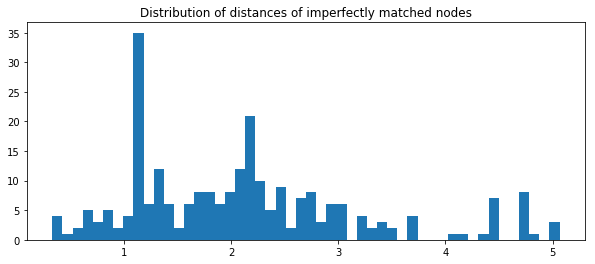

In [367]:
f = plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 1, 1)
ax.set_title('Distribution of distances of imperfectly matched nodes')
n, bins, patches = ax.hist(distances[distances[:,0] != 0][:,0], 50)
# n, bins, patches = ax.hist(distances[:,1], 50, alpha=0.5)